In [7]:
pip install --upgrade openeo


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install xarray --upgrade

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 10.8 MB/s  0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openeo 0.46.0 requires xarray<2025.01.2,>=0.12.3, but you have xarray 2025.10.1 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install netCDF4 h5netcdf

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
#imports
import pandas as pd
import os
import glob
from tqdm import tqdm 
import ast

import openeo
from openeo.extra import spectral_indices
import requests
import xarray
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import torch
from datetime import datetime

#from torch.utils.data import DataLoader, Dataset
from xarray import Dataset

# updating metadata
from openeo.metadata import CollectionMetadata

device = 'cuda' if torch.cuda.is_available() else 'cpu'

C:\Users\Ulli\AppData\Local\Temp\ipykernel_9340\3798506119.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Data Loading

In [2]:
def create_bbox_from_radius(lon, lat, radius_meters):
    """
    Creates a bounding box from a center point (lon, lat) and a radius in meters.
    """
    # Define the projections: WGS84 (lat/lon) and a metric projection (Mercator)
    wgs84 = pyproj.CRS("EPSG:4326")
    mercator = pyproj.CRS("EPSG:3857")

    # Create a transformer to switch between projections
    project_to_mercator = pyproj.Transformer.from_crs(wgs84, mercator, always_xy=True).transform
    project_to_wgs84 = pyproj.Transformer.from_crs(mercator, wgs84, always_xy=True).transform

    # Define a point and project it into the metric system
    point_wgs84 = Point(lon, lat)
    point_mercator = transform(project_to_mercator, point_wgs84)

    # Create a buffer (circle) around the metric point
    buffer_mercator = point_mercator.buffer(radius_meters)

    # Project the buffer back to WGS84
    buffer_wgs84 = transform(project_to_wgs84, buffer_mercator)
    
    # Return the bounds of the buffer
    return buffer_wgs84.bounds

In [5]:
def group_timestamps_by_year(timestamp_list):
    """
    convert list of timestamps (strings) into a dictionary grouped by year

    Args:
        timestamp_list (list): list of timestamp strings in the format 'YYYY-MM-DDTHH
    
    Returns:
        dict: dictionary with years as keys and lists of timestamps as values
    
    """
    year_dict = {}
    
    # Early exit if the input list is empty
    if not timestamp_list:
        return year_dict
        
    for ts in timestamp_list:
        # get first 4 characters as year
        year = ts[:4] 
        
        # write year as key into dict
        if year not in year_dict:
            year_dict[year] = []
            
        # append timestamp to the corresponding year list
        year_dict[year].append(ts)
        
    return year_dict

In [6]:
def to_date(d): 
    return datetime.strptime(d, '%Y-%m-%d')

In [7]:
def load_coll(conn, time, bbox):
    '''Load collection from OpenEO for one day with MNDWI index computation and merging.

    Returns:
        
        merged_cube: xarray DataCube with original bands and MNDWI index.
    '''
    datacube = conn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=(time, time),
    spatial_extent={
        "west": bbox["west"],
        "south": bbox["south"],
        "east": bbox["east"],
        "north": bbox["north"],
        "crs": "EPSG:4326",
    },
    bands=["B04", "B11", "B03", "B02", "SCL"],
    max_cloud_cover=5,
    )
    indices_img = spectral_indices.compute_index(datacube, 'MNDWI') #compute MNDWI index
    merged_cube = datacube.merge_cubes(indices_img) # Merge the original cube and the indices cube
    
    return merged_cube

In [8]:
def create_water_masks(ds, filename):
    '''Creating water masks as ground truth.
       Filter for only images with water pixels.

    Returns:
        
        combined_mask: xarray datacube containing the combined water mask of SCL band and MNDWI index.
        check_mask: boolean indicating if water pixels were found in both masks.
    '''
    try:
        # Create water masks
        mndwi_mask = ds['MNDWI'] > 0.0
        scl_mask = ds['SCL'] == 6
        # check if there are any water pixels in each mask
        mndwi_water_true = mndwi_mask.any()
        scl_water_true = scl_mask.any()

        has_water = mndwi_water_true.item() or scl_water_true.item()

        if not has_water:
            print(f"Warning: No water pixels found in either mask for {filename}.")
            combined_mask = None
            check_mask = False
        else:
            print(f"Water pixels found for {filename}: MNDWI: {mndwi_water_true.item()}, SCL: {scl_water_true.item()}")
            #combine both masks
            combined_mask = (mndwi_mask | scl_mask)
            check_mask = True
    except Exception as e:
        print(f"Error creating water masks for {filename}: {e}")
        combined_mask = None
        check_mask = False
    return combined_mask, check_mask

In [9]:
path_root = ("./data/")

In [ ]:
def download_and_map_data(root_path):
    '''Loads the IFMHA ground truth data, connects to OpenEO, downloads Sentinel-2 data for specified locations and dates,
       creates water masks, and saves metadata.
        '''
    
    path_sentinel2 = os.path.join(root_path, "sentinel2/")
    path_watermask = os.path.join(root_path, "watermasks/")
    os.makedirs(path_sentinel2, exist_ok=True)
    os.makedirs(path_watermask, exist_ok=True)
    
    # load csv data
    df = pd.read_csv(os.path.join(root_path, "IFMHA_ground_truth.csv"), sep=",", encoding='utf-8')
    df['date_only'] = df['measurement_dt'].apply(lambda x: x.split(' ')[0])
    top30_counts = df['site_no'].value_counts().head(30).index
    df = df[df['site_no'].isin(top30_counts)]
    # create csv for data to save in the meantime
    metadata_path = os.path.join(root_path, "dataset_metadata.csv")
    
    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        processed_ids = set(metadata_df['original_id'].astype(str) + "_" + metadata_df['requested_date'])
    else:
        metadata_df = pd.DataFrame(columns=['original_id', 'bbox', 'requested_date', 'found_date', 'file_path'])
        processed_ids = set()

    #openeo connection
    connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()
    
    #create df with grouped timestamps, lat, lon for each site_no
    grouped_df = df.groupby('site_no').agg(
        timestamps=('date_only', list),
        Lat=('LatSite', 'first'),
        Lon=('LonSite', 'first')
    )
    
    radius = 5000 #define a radius for defining the bounding box around the specific point
    bbox_keys = ("west", "south", "east", "north") #define keys for bounding box dictionary

    # iterate over groups and create dictionary with bounding boxes and timestamps for each river point
    for row in tqdm(grouped_df.itertuples(), total=len(grouped_df), desc="Processing Locations"):
        id_river = row.Index
        bbox = dict(zip(bbox_keys, create_bbox_from_radius(row.Lon, row.Lat, radius)))
        timestamps = group_timestamps_by_year(row.timestamps)

        for year, date_list in timestamps.items():

            try:
                #create GeoJSON-Polygon-Dictionary
                polygon_geojson = {
                    "type": "Polygon",
                    "coordinates": [
                        [[bbox["west"], bbox["south"]], 
                         [bbox["east"], bbox["south"]], 
                         [bbox["east"], bbox["north"]],
                         [bbox["west"], bbox["north"]], 
                         [bbox["west"], bbox["south"]]]
                    ]
                }
                
                #get timestamps in the specific year
                check_datacube = connection.load_collection(
                    "SENTINEL2_L2A",
                    temporal_extent=(date_list[0] , date_list[-1]),
                    spatial_extent={
                        "west": bbox["west"],
                        "south": bbox["south"],
                        "east": bbox["east"],
                        "north": bbox["north"],
                        "crs": "EPSG:4326",
                    },
                    bands=["SCL"],
                    max_cloud_cover=5,
                )
                
                # Spatial aggregation: mean per timestamp
                agg = (
                check_datacube.aggregate_spatial(geometries=polygon_geojson, reducer='mean')
                )
                result_dict = agg.execute() #get list of available timestamps in datacube

                available_timestamps_list = list(result_dict.keys()) #get list for the timestamps
                available_timestamps_list = [x.split('T')[0] for x in available_timestamps_list]  #extract date only
                available_timestamps_list = [to_date(x) for x in available_timestamps_list] #convert to datetime

                for req_date_str in date_list:
                    req_date = to_date(req_date_str) #convert to datetime
                    unique_key = f"{id_river}_{req_date_str}" #get key for csv
                    
                    if unique_key in processed_ids:
                        continue #skip already processed entries

                    found_date = None #reset found date for each request
                    combined_mask = None
                    check_mask = False

                    if req_date in available_timestamps_list:
                        found_date = req_date #get found date if exact match
                        print(f"Exact date found: {found_date}")
                    else:
                        nearest_date = min(available_timestamps_list, key=lambda x: abs(x - req_date)) #find nearest date
                        #get only a max difference of 10 days
                        delta_days = abs((nearest_date - req_date).days)
                        if delta_days <= 20: 
                            found_date = nearest_date
                            print(f"Exact date {req_date} NOT found in datacube. Get img from {found_date} with diff {delta_days} days")
                        else:
                            print(f"No image close to {req_date}. Diff of {delta_days} days")
                            found_date = None

                    if found_date:
                        found_date_str = str(found_date).split(' ')[0] #define filename
                        filename = f"sentinel2_{id_river}_{found_date_str}.nc" #define path
                        out_path_sen2 = os.path.join(path_sentinel2, filename)
                        out_path_mask = os.path.join(path_watermask, f"watermask_{id_river}_{found_date_str}.nc")

                        if not os.path.exists(out_path_sen2):
                            try:
                                datacube = load_coll(connection, found_date, bbox) #get collection for just one date and river
                                datacube.download(out_path_sen2) # Download the merged cube as a NetCDF file
                                
                                #create water masks and check for water pixels
                                with xarray.open_dataset(out_path_sen2) as ds: # Convert to xarray Dataset
                                    combined_mask, check_mask = create_water_masks(ds, filename)
                                
                                if check_mask == True:
                                    combined_mask.to_netcdf(out_path_mask)
                            
                            except Exception as e:
                                print(f" Download error {filename}: {e}")

                        new_row = {
                            'original_id': id_river,
                            'bbox': str(bbox),
                            'requested_date': req_date_str,
                            'found_date': found_date_str,
                            'file_path': filename,
                            'water_mask': check_mask,
                        }
                        
                        metadata_df = pd.concat([metadata_df, pd.DataFrame([new_row])], ignore_index=True)
                        processed_ids.add(unique_key)
                        
                        metadata_df.to_csv(metadata_path, index=False)

            except Exception as e:
                print(f"Error with ID {id_river}: {e}")
                with open("errors.log", "a") as f:
                    f.write(f"{id_river},{year},{str(e)}\n")

download_and_map_data(path_root)

Authenticated using refresh token.


Processing Locations:   0%|          | 0/1 [00:00<?, ?it/s]

No image close to 2016-02-04 00:00:00. Diff of 141 days
No image close to 2016-03-23 00:00:00. Diff of 93 days
No image close to 2016-03-23 00:00:00. Diff of 93 days
No image close to 2016-05-10 00:00:00. Diff of 45 days
No image close to 2016-05-10 00:00:00. Diff of 45 days
Exact date 2016-07-07 00:00:00 NOT found in datacube. Get img from 2016-06-24 00:00:00 with diff 13 days
Water pixels found for sentinel2_1038000_2016-06-24.nc: MNDWI: True, SCL: True
Exact date 2016-08-16 00:00:00 NOT found in datacube. Get img from 2016-08-23 00:00:00 with diff 7 days
Water pixels found for sentinel2_1038000_2016-08-23.nc: MNDWI: True, SCL: True
Exact date 2016-09-06 00:00:00 NOT found in datacube. Get img from 2016-09-12 00:00:00 with diff 6 days
Water pixels found for sentinel2_1038000_2016-09-12.nc: MNDWI: True, SCL: True
No image close to 2016-12-08 00:00:00. Diff of 87 days
No image close to 2016-12-08 00:00:00. Diff of 87 days
No image close to 2017-01-25 00:00:00. Diff of 165 days
No image

Processing Locations: 100%|██████████| 1/1 [04:54<00:00, 294.03s/it]

Water pixels found for sentinel2_1038000_2019-03-26.nc: MNDWI: True, SCL: True
No image close to 2019-06-19 00:00:00. Diff of 85 days


In [ ]:
class Dataset_Sen2():
    '''Creating dataset for sentinel 2 images.

    Returns:
        ds: xarray datacube containing the image
    '''
    def __init__(self, path_root):
        self.root = path_root
        self.path_sentinel2 = os.path.join(self.root, "sentinel2/")
        
        #load metadata csv
        metadata_path = os.path.join(self.root, "dataset_metadata.csv")
        if not os.path.exists(metadata_path):
            raise FileNotFoundError("File Not Found!")
            
        self.metadata = pd.read_csv(metadata_path)
        self.metadata = self.metadata[self.metadata['water_mask'] == True] #get only imgs where water mask found
        self.metadata = self.metadata['found_date'].drop_duplicates(keep='first') #filter for unique found dates
        self.df = pd.read_csv(os.path.join(self.root, "IFMHA_ground_truth.csv"))

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        river_id = row['original_id']
        found_date = row['found_date']
        filename = row['file_path']
        
        # parse bbox string back to dictionary
        bbox = ast.literal_eval(row['bbox']) 
        #load data
        filepath = os.path.join(self.path_sentinel2, filename)
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"No file: {filepath}")

        ds = xarray.open_dataset(filepath)

        return ds, bbox, river_id, found_date

sen2_dataset = Dataset_Sen2(path_root)

In [ ]:
class Mask_Dataset():
    '''Creating water masks - Loads the dataset of Sentinel-2 and creates water masks as ground truth.
       Filter for only images with water pixels.

    Returns:
        
        ds: xarray datacube containing the combined water mask of SCL band and MNDWI index.
    '''
    def __init__(self, path_root):
        self.root = path_root # Root path where the data is located
        self.path_watermask = os.path.join(self.root, "water_mask/")

        #load metadata csv
        metadata_path = os.path.join(self.root, "dataset_metadata.csv")
        if not os.path.exists(metadata_path):
            raise FileNotFoundError("File Not Found!")
            
        self.metadata = pd.read_csv(metadata_path)
        self.metadata = self.metadata[self.metadata['water_mask'] == True] #get only imgs where water mask found
        self.metadata = self.metadata['found_date'].drop_duplicates(keep='first') #filter for unique found dates
        self.df = pd.read_csv(os.path.join(self.root, "IFMHA_ground_truth.csv"))

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        river_id = row['original_id']
        found_date = row['found_date']
        filename = row['file_path']
        
        # parse bbox string back to dictionary
        bbox = ast.literal_eval(row['bbox']) 
        #load data
        filepath = os.path.join(self.path_watermask, f"watermask_{river_id}_{found_date}.nc")
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"No file: {filepath}")

        water_mask = xarray.open_dataset(filepath)

        return water_mask, bbox, river_id, found_date
    
    def __len__(self):
        return len(self.metadata)
    
mask_dataset = Mask_Dataset(path_root)

# 2. Explore the data

In [46]:
df = pd.read_csv(os.path.join(path_root, "IFMHA_ground_truth.csv"), sep=",", encoding='utf-8')

In [47]:
len(df)

10989

In [43]:
df

,site_no,STATE,party_nm,station_nm,measurement_dt,tz_cd,measured_rating_diff,LatSite,LonSite,control_type_cd,...,max_depth,side_slope,chan_bottom_width,parabola_coeff,arc_length,wetted_perimeter,manning_n,year,month,day
0,1010070,ME,JRC/SGS,"Big Black River near Depot Mtn, Maine",2016-05-24 08:14:30,EDT,Good,46.893889,-69.751667,Clear,...,1.751905,1.532891,76.264799,0.001039,84.106444,82.677590,0.028982,2016,5,24
1,1010070,ME,JRC,"Big Black River near Depot Mtn, Maine",2016-09-08 08:43:00,EDT,Fair,46.893889,-69.751667,Clear,...,1.075333,1.532891,76.264799,0.001039,75.075782,80.201023,0.082988,2016,9,8
2,1010070,ME,JRC,"Big Black River near Depot Mtn, Maine",2016-10-24 07:24:05,EDT,Good,46.893889,-69.751667,Clear,...,10.742920,1.532891,76.264799,0.001039,113.258892,115.588913,0.031890,2016,10,24
3,1010070,ME,JRP/ALU,"Big Black River near Depot Mtn, Maine",2017-04-18 14:52:09,EDT,Fair,46.893889,-69.751667,Clear,...,9.208286,1.532891,76.264799,0.001039,105.207765,109.971433,0.036085,2017,4,18
4,1010070,ME,JRC/HSG,"Big Black River near Depot Mtn, Maine",2017-05-03 08:37:23,EDT,Good,46.893889,-69.751667,Clear,...,12.062397,1.532891,76.264799,0.001039,121.317767,120.418814,0.030754,2017,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26719,13351000,WA,WRE,"PALOUSE RIVER AT HOOPER, WA",2021-01-14 13:29:00,PST,Fair,46.758483,-118.148849,Clear,...,14.098411,2.207381,55.396105,0.001867,107.707475,123.726319,0.060330,2021,1,14
26720,13351000,WA,MRM,"PALOUSE RIVER AT HOOPER, WA",2021-03-25 11:39:52,PDT,Good,46.758483,-118.148849,Clear,...,9.884857,2.207381,55.396105,0.001867,105.668685,103.304653,0.118396,2021,3,25
26721,13351000,WA,DKB/KLC,"PALOUSE RIVER AT HOOPER, WA",2021-12-15 15:58:03,PST,Good,46.758483,-118.148849,Clear,...,7.683462,2.207381,55.396105,0.001867,93.769695,92.635237,0.275458,2021,12,15
26722,13351000,WA,WRE,"PALOUSE RIVER AT HOOPER, WA",2022-03-03 11:45:52,PST,Fair,46.758483,-118.148849,Clear,...,14.367143,2.207381,55.396105,0.001867,105.668685,125.028770,0.058346,2022,3,3


In [57]:
df['date_only'] = df['measurement_dt'].apply(lambda x: x.split(' ')[0])
top30_counts = df['site_no'].value_counts().head(30).index
dftop30 = df[df['site_no'].isin(top30_counts)]

In [58]:
dftop30

,site_no,STATE,party_nm,station_nm,measurement_dt,tz_cd,measured_rating_diff,LatSite,LonSite,control_type_cd,...,side_slope,chan_bottom_width,parabola_coeff,arc_length,wetted_perimeter,manning_n,year,month,day,date_only
205,1031510,ME,ALU,"Black Stream near Dover-Foxcroft, Maine",2016-04-25 11:01:00,EDT,Good,45.150278,-69.236389,Clear,...,1.643085,21.416079,0.004725,31.615933,26.474616,0.040022,2016,4,25,2016-04-25
206,1031510,ME,ALU,"Black Stream near Dover-Foxcroft, Maine",2016-06-20 17:49:30,EDT,Good,45.150278,-69.236389,Clear,...,1.643085,21.416079,0.004725,24.051346,24.817411,0.054563,2016,6,20,2016-06-20
207,1031510,ME,ALU,"Black Stream near Dover-Foxcroft, Maine",2016-08-15 13:19:00,EDT,Good,45.150278,-69.236389,Clear,...,1.643085,21.416079,0.004725,22.240650,23.662689,0.074645,2016,8,15,2016-08-15
208,1031510,ME,ALU/HSG,"Black Stream near Dover-Foxcroft, Maine",2017-04-05 14:48:30,EDT,Good,45.150278,-69.236389,Clear,...,1.643085,21.416079,0.004725,33.133254,28.503066,0.037914,2017,4,5,2017-04-05
209,1031510,ME,ALU/HSG,"Black Stream near Dover-Foxcroft, Maine",2017-04-05 14:53:30,EDT,Good,45.150278,-69.236389,Clear,...,1.643085,21.416079,0.004725,32.323817,28.680096,0.037962,2017,4,5,2017-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10872,13247500,ID,IDC,PAYETTE RIVER NR HORSESHOE BEND ID,2021-12-17 12:48:25,MST,Good,43.943333,-116.196667,Clear,...,2.403273,204.847862,0.000213,229.090970,226.632087,0.069112,2021,12,17,2021-12-17
10873,13247500,ID,IDC/RMF,PAYETTE RIVER NR HORSESHOE BEND ID,2022-03-21 15:29:09,MDT,Good,43.943333,-116.196667,Clear,...,2.403273,204.847862,0.000213,235.098308,231.386059,0.055246,2022,3,21,2022-03-21
10874,13247500,ID,IDC,PAYETTE RIVER NR HORSESHOE BEND ID,2022-05-25 14:48:39,MDT,Good,43.943333,-116.196667,Clear,...,2.403273,204.847862,0.000213,242.107355,242.046982,0.041387,2022,5,25,2022-05-25
10875,13247500,ID,IDC/MKK,PAYETTE RIVER NR HORSESHOE BEND ID,2022-07-18 12:03:13,MDT,Good,43.943333,-116.196667,Clear,...,2.403273,204.847862,0.000213,242.107355,237.907962,0.041901,2022,7,18,2022-07-18


In [30]:
#get a sample of the sen2_dataset
ds, bbox, id, date = sen2_dataset[1]

In [31]:
ds

<xarray.Dataset> Size: 13MB
Dimensions:  (t: 1, x: 724, y: 721)
Coordinates:
  * t        (t) datetime64[ns] 8B 2016-08-23
  * x        (x) float64 6kB 4.489e+05 4.49e+05 4.49e+05 ... 4.562e+05 4.562e+05
  * y        (y) float64 6kB 4.9e+06 4.9e+06 4.9e+06 ... 4.893e+06 4.893e+06
Data variables:
    crs      |S1 1B ...
    B04      (t, y, x) float32 2MB ...
    B11      (t, y, x) float32 2MB ...
    B03      (t, y, x) float32 2MB ...
    B02      (t, y, x) float32 2MB ...
    SCL      (t, y, x) float32 2MB ...
    MNDWI    (t, y, x) float32 2MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

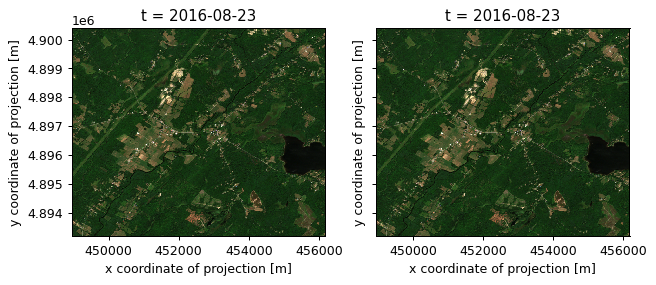

In [32]:
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")
fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1])

c:\Users\Ulli\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


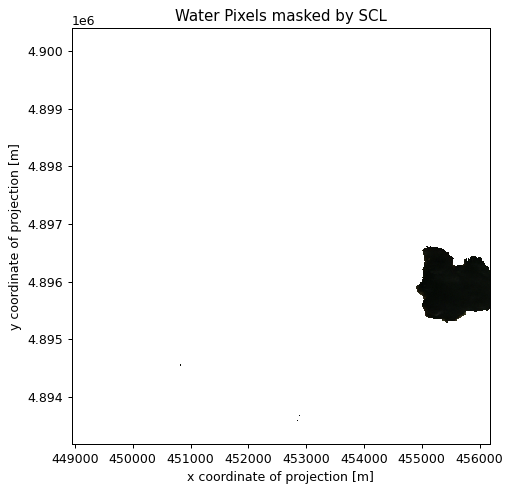

In [33]:
# keep the water pixels, where the SCL value is 6
cube_masked = ds.where(ds.SCL == 6)
# Select the RGB bands for plotting and convert to a DataArray
rgb_masked = cube_masked[["B04", "B03", "B02"]].to_array(dim="bands")
# Select the first time step for plotting
first_timestep_masked = rgb_masked.isel(t=0)

# Plot the result
fig, ax = plt.subplots(figsize=(6, 6), dpi=90)
first_timestep_masked.plot.imshow(vmin=0, vmax=2000, ax=ax, robust=True)
ax.set_title("Water Pixels masked by SCL")
plt.show()

https://open-eo.github.io/openeo-python-client/cookbook/spectral_indices.html#openeo.extra.spectral_indices.compute_index

https://awesome-ee-spectral-indices.readthedocs.io/en/latest/list.html#water

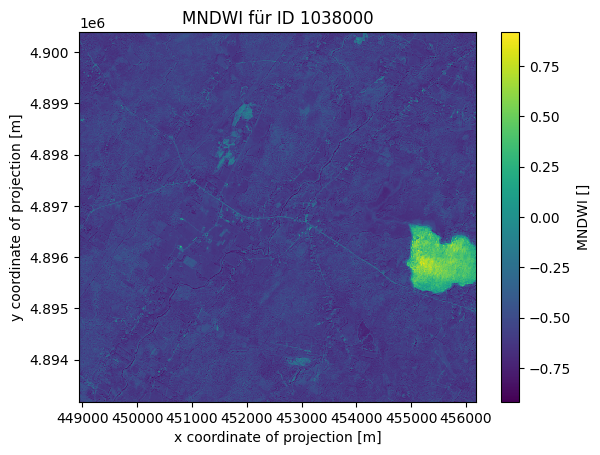

In [34]:
ds['MNDWI'].isel(t=0).plot(cmap='viridis')
plt.title(f"MNDWI für ID {id}")
plt.show()

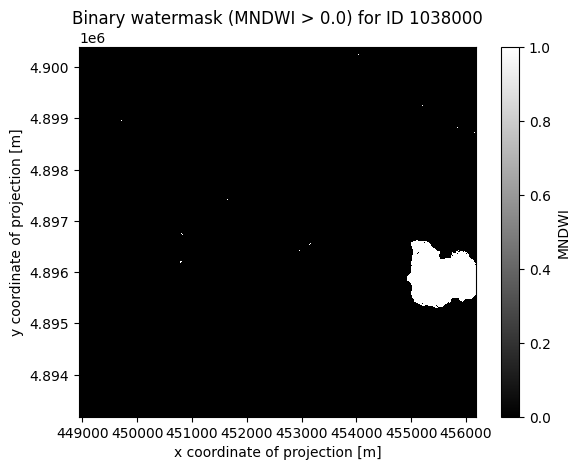

In [35]:
#get mndwi data for first time step
mndwi_data = ds['MNDWI'].isel(t=0)
# define threshold by 0 (water is positive, land is negative)
threshold = 0.0
#every pixel with mndwi value greater than threshold is water (true), else land (false)
water_mask = (mndwi_data > threshold)
# plot binary mask
water_mask.plot(cmap='gray')
plt.title(f"Binary watermask (MNDWI > {threshold}) for ID {id}")
plt.show()

Is there any mndwi-waterpixel? True
Is there any scl-waterpixel? True


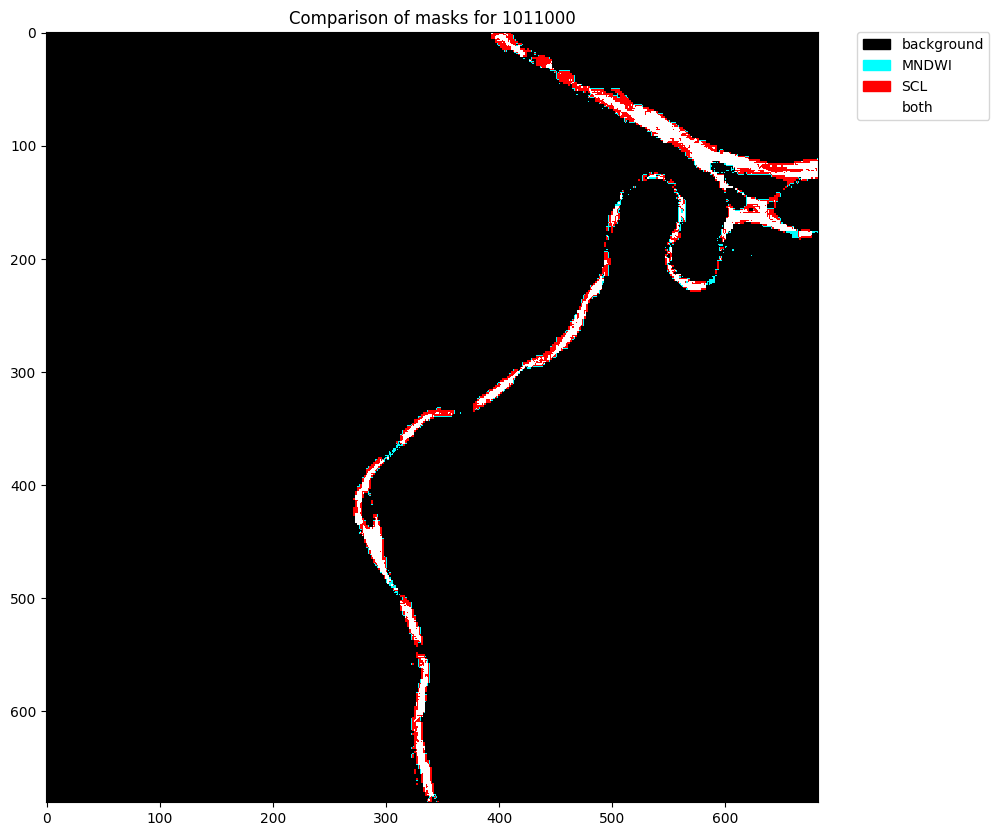

In [59]:
#compare MNDWI watermask with SCL watermask 
#get data for first time step
mndwi_mask = ds['MNDWI'].isel(t=0) > 0.0
scl_mask = ds['SCL'].isel(t=0) == 6

# check if there are any water pixels in each mask
mndwi_water_true = mndwi_mask.any()
scl_water_true = scl_mask.any()
print(f"Is there any mndwi-waterpixel? {mndwi_water_true.item()}")
print(f"Is there any scl-waterpixel? {scl_water_true.item()}")

# 2. create numerical comparison mask
# Values:
# 0: background
# 1: mndwi only
# 2: scl only
# 3: both
comparison_mask = np.zeros_like(mndwi_mask, dtype=int)
comparison_mask[mndwi_mask] = 1
comparison_mask[scl_mask] = 2
comparison_mask[mndwi_mask & scl_mask] = 3

# 3. Define colors and labels for the legend
cmap = mcolors.ListedColormap(['black', 'cyan', 'red', 'white'])
labels = {
    0: 'background',
    1: 'MNDWI',
    2: 'SCL',
    3: 'both'
}
patches = [mpatches.Patch(color=cmap.colors[i], label=labels[i]) for i in range(len(labels))]

# plot the mask with legend
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(comparison_mask, cmap=cmap)
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title(f"Comparison of masks for {id}")
plt.show()

Number of water pixels in combined mask: 11739


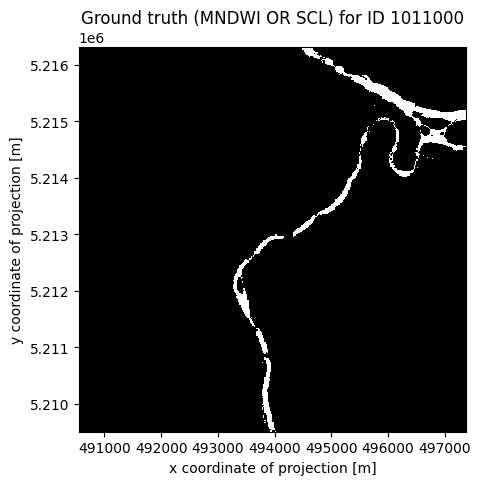

In [60]:
#combine both masks
combined_mask = (mndwi_mask | scl_mask)
water_pixel_count = combined_mask.sum().item()
print(f"Number of water pixels in combined mask: {water_pixel_count}")
# plot the combined mask
fig, ax = plt.subplots(figsize=(5, 5))
combined_mask.plot(ax=ax, cmap='gray', add_colorbar=False)
ax.set_title(f"Ground truth (MNDWI OR SCL) for ID {id}")
plt.show()

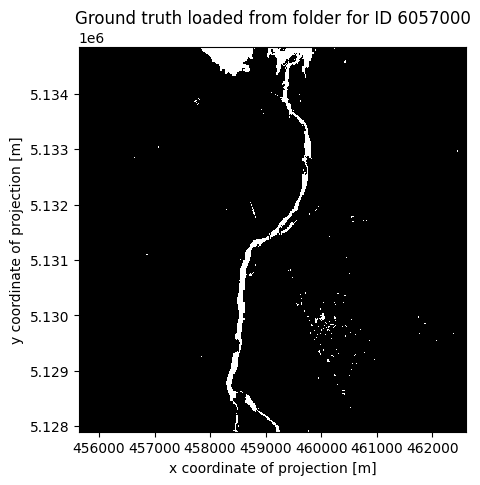

In [168]:
#get a sample of the mask_dataset
water_mask, id_list_masks = mask_dataset[1]
id_mask = id_list_masks[1]
water_mask = water_mask.to_array(dim="bands")
# plot the combined mask
fig, ax = plt.subplots(figsize=(5, 5))
water_mask.plot(ax=ax, cmap='gray', add_colorbar=False)
ax.set_title(f"Ground truth loaded from folder for ID {id_mask}")
plt.show()

# 3. Fine-Tune DeepLabV3+

In [7]:
#imports
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [11]:
len(sen2_dataset)

43

In [12]:
len(mask_dataset)

24

In [13]:
mask_dataset.water_id

[6054500,
 6057000,
 6063000,
 6064150,
 6065500,
 6066500,
 6073500,
 6075700,
 6077100,
 6078500,
 6080900,
 6085800,
 6088300,
 6088500,
 6090300,
 6090500,
 6090570,
 6090800,
 6097200,
 6099500,
 6100300,
 6102050,
 6102500,
 6108800]

In [16]:
sen2_dataset.IDs

[6054500,
 6057000,
 6058900,
 6061900,
 6062500,
 6062750,
 6063000,
 6064150,
 6065500,
 6066500,
 6071300,
 6073500,
 6075700,
 6075775,
 6076550,
 6076560,
 6077100,
 6077500,
 6078500,
 6080900,
 6085800,
 6088300,
 6088500,
 6090300,
 6090500,
 6090570,
 6090800,
 6091700,
 6093200,
 6093600,
 6097200,
 6098500,
 6098700,
 6098900,
 6099000,
 6099500,
 6100300,
 6102050,
 6102500,
 6108000,
 6108800,
 462853112144101,
 462922112145401]

In [17]:
sen2_id_to_idx = [i for i, gage_id in enumerate(sen2_dataset.IDs) if gage_id in mask_dataset.water_id]

In [18]:
sen2_id_to_idx

[0,
 1,
 6,
 7,
 8,
 9,
 11,
 12,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 30,
 35,
 36,
 37,
 38,
 40]

In [19]:
len(sen2_id_to_idx)

24

In [169]:
# create training dataset
class TrainingDataset(Dataset):
    def __init__(self, sen2_dataset, mask_dataset):
        self.sentinel_data = sen2_dataset
        self.mask_data = mask_dataset
        # get valid ids, which has water masks
        self.valid_ids = self.mask_data.water_id
        # map valid ids to the gage_id in the sentinel dataset and get the index of this id
        self.sen2_id_to_idx = [i for i, gage_id in enumerate(self.sentinel_data.IDs) if gage_id in self.valid_ids]

    #get len of valid ids
    def __len__(self):
        return len(self.valid_ids)

    def __getitem__(self, idx):
        #get valid id and find in corresponding sentinel dataset
        sen2_idx = self.sen2_id_to_idx[idx]
        #get sentinel data and mask data
        ds, _, _ = self.sentinel_data[sen2_idx]
        water_mask, _ = self.mask_data[idx]

        #get rgb data
        # Convert xarray DataSet to a (bands, t, x, y) DataArray
        rgb_data = ds[["B04", "B03", "B02"]].to_array(dim="bands").isel(t=0)
        rgb_data = rgb_data.fillna(0.0) #fill nan with 0 -> there are nan-values because i define a bb by myself - and there is the possibility that there is no data, when the satellite did not capture any data there
        image_numpy = rgb_data.to_numpy().astype('float32') / 10000.0
        image_numpy = image_numpy.transpose(1, 2, 0)  # Change to (H, W, C)

        #get ground truth water mask
        water_mask = water_mask.to_dataarray() #convert Dataset to dataarray
        water_mask_np = water_mask.to_numpy().astype('int64') # Convert to numpy array (int for crossentropy loss)

        # Define a fixed size for all images and masks
        target_size = (512, 512)

        #convert image to tensor
        preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(target_size), #bilinear interpolation for satellite image 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_image = preprocess(image_numpy)
        #input_image = input_image.squeeze(0) # create a mini-batch as expected by the model
        
        mask_tensor = torch.from_numpy(water_mask_np)
        #print(f"mask_np: {water_mask_np.shape}")
        mask_tensor = transforms.functional.resize(mask_tensor, target_size, interpolation=transforms.InterpolationMode.NEAREST) #2 label - nearest neighbor interpolation for mask (every pixel get the value of the closest pixel)
        #print(f"mask_tensor_unsqueezed: {mask_tensor.shape}")
        mask_tensor = mask_tensor.squeeze()
        #print(f"input_SHAPE: {input_image.shape}")
        #print(f"mask_tensor_shape: {mask_tensor.shape}")

        if torch.isnan(input_image).any():
            print(input_image)
            raise ValueError(f"NaN DETECTED IN IMAGE! (idx {idx})")

        if torch.isnan(mask_tensor).any():
            print(mask_tensor)
            raise ValueError(f"NaN DETECTED IN MASK! (idx {idx})")
        
        sample = {'image' : input_image, 'mask': mask_tensor}

        return sample

In [170]:
train_data = TrainingDataset(sen2_dataset, mask_dataset)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True) #stack data into batches of 2

In [171]:
len(train_data)

24

In [172]:
train_data[6]

{'image': tensor([[[-1.5317, -1.5583, -1.5899,  ..., -1.4705, -1.5051, -1.5383],
          [-1.5466, -1.5610, -1.5835,  ..., -1.4667, -1.4968, -1.5066],
          [-1.5730, -1.5635, -1.5706,  ..., -1.4409, -1.4672, -1.4680],
          ...,
          [-1.5818, -1.5695, -1.5662,  ..., -1.8155, -1.8321, -1.7658],
          [-1.5689, -1.5675, -1.5531,  ..., -1.8684, -1.8943, -1.7840],
          [-1.5337, -1.5352, -1.5477,  ..., -1.7744, -1.8193, -1.8281]],
 
         [[-1.5424, -1.5593, -1.5888,  ..., -1.4876, -1.5055, -1.5281],
          [-1.5490, -1.5580, -1.5783,  ..., -1.4820, -1.5052, -1.4996],
          [-1.5686, -1.5648, -1.5736,  ..., -1.4720, -1.4813, -1.4807],
          ...,
          [-1.5752, -1.5653, -1.5618,  ..., -1.7688, -1.7948, -1.7144],
          [-1.5609, -1.5679, -1.5624,  ..., -1.8080, -1.8262, -1.7371],
          [-1.5536, -1.5579, -1.5639,  ..., -1.7428, -1.7866, -1.7831]],
 
         [[-1.4247, -1.4419, -1.4792,  ..., -1.4038, -1.4110, -1.4261],
          [-1.4308,

In [173]:
train_data[0]['mask'].shape

torch.Size([512, 512])

In [180]:
#load pre-trained DeepLabV3 model for semantic segmentation
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True).to(device)

Using cache found in /home/myuser/.cache/torch/hub/pytorch_vision_v0.10.0


In [181]:
#modify classifier to output 2 classes (background and water)
#get last layer (layer 4)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
# train the model
#model.train()

In [182]:
# Function to calculate Dice coefficient
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)      # Flatten the predictions
    targets = targets.contiguous().view(-1)  # Flatten the targets

    intersection = (preds * targets).sum().cpu()  # Calculate intersection (calculates the number of overlapping pixels (true positives) by using element-by-element multiplication.)
    dice = (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth).cpu() # Dice formula (The smooth parameter ensures that there is no division by zero if the sums of predictions and targets are zero.)
    return dice

In [176]:
#define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss()

# Training parameters
num_epochs = 20   # Number of epochs to train the model
train_losses = [] # List to store training losses
val_losses = []   # List to store validation losses
train_dices = []  # List to store training Dice scores
val_dices = []    # List to store validation Dice scores

#training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    epoch_dice = 0  # Initialize epoch Dice score
    
    for batch in train_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad() #zero the gradients
        outputs = model(images)['out'] # Forward pass
        loss = criterion(outputs, masks) # Compute loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  # Accumulate loss

        # Calculate Dice coefficient
        preds = (outputs > 0.5).float()  # Threshold predictions
        dice = dice_score(preds, masks) # Calculate Dice score
        epoch_dice += dice  # Accumulate Dice score

    avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    avg_dice = epoch_dice / len(train_loader)  # Average Dice score for the epoch
    train_losses.append(avg_loss)  # Store average training loss
    train_dices.append(avg_dice)   # Store average training Dice score

    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_loss = 0  # Initialize validation loss
    val_dice = 0  # Initialize validation Dice score
    with torch.no_grad():  # Disable gradient calculation
        for images, masks in val_loader:
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)    # Move masks to GPU

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Calculate loss
            val_loss += loss.item()  # Accumulate validation loss

            # Calculate Dice coefficient
            preds = (outputs > 0.5).float()  # Threshold predictions
            dice = dice_score(preds, masks)  # Calculate Dice score
            val_dice += dice  # Accumulate validation Dice score

    avg_val_loss = val_loss / len(val_loader)  # Average validation loss for the epoch
    avg_val_dice = val_dice / len(val_loader)  # Average validation Dice score for the epoch
    val_losses.append(avg_val_loss)  # Store average validation loss
    val_dices.append(avg_val_dice)   # Store average validation Dice score
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss}, Train Dice: {avg_dice}, Val Loss: {avg_val_loss}, Val Dice: {avg_val_dice}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient over Epochs')

plt.show()


print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete.")
#model returns ordered dict with key 'out' containing the semantic masks

Epoch [1/5], Loss: 0.6693
Epoch [2/5], Loss: 0.7057
Epoch [3/5], Loss: 0.6634
Epoch [4/5], Loss: 0.6445
Epoch [5/5], Loss: 0.6530
Training complete.


In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data = ds[["B04", "B03", "B02"]].to_array(dim="bands").isel(t=0) #select first time step
data_numpy = data.to_numpy().astype('float32') / 10000.0 # Scale to [0, 1] range, because tensor expect a specific range [normal: 0, 255] - Sentinel2 higher (0, 10000)
# Transpose dimensions from (C, H, W) to (H, W, C) for creating a tensor
data_numpy_transposed = data_numpy.transpose(1, 2, 0)
input_tensor = preprocess(data_numpy_transposed)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [36]:
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

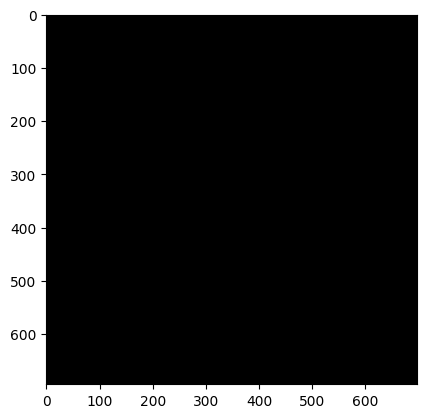

In [41]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
output_image_size = (data.shape[2], data.shape[1])
# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(output_image_size)
r.putpalette(colors)

plt.imshow(r)
plt.show()

# 4. Calculate river width 

In [186]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.5 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
! conda create -n rivgraph_env rivgraph -c conda-forge

Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ 

In [ ]:
! conda activate myenv

In [ ]:
! conda install rivgraph -c conda-forge

In [7]:
! conda '/home/myuser/prj/code/RivGraph/environment.yml' install

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: '/home/myuser/prj/code/RivGraph/environment.yml' (choose from 'activate', 'build', 'clean', 'commands', 'compare', 'config', 'convert', 'create', 'deactivate', 'debug', 'develop', 'doctor', 'env', 'export', 'index', 'info', 'init', 'inspect', 'install', 'list', 'metapackage', 'notices', 'package', 'remove', 'rename', 'render', 'repoquery', 'run', 'search', 'skeleton', 'uninstall', 'update', 'upgrade')


In [183]:
#imports
from rivgraph import im_utils

ModuleNotFoundError: No module named 'rivgraph'

# 5. Construct the cross-section